This notebook will be used for the Applied Data Science Capstone Project

In [65]:
import requests
import json
from bs4 import BeautifulSoup
import re
import csv
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [23]:
#Store the URL for the wikipedia page
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#Get the HTML text for the URL
resp = requests.get(URL)
html_code = resp.text

In [24]:
#Instantiate html parser object
soup = BeautifulSoup(html_code)

#Get the first table on the webpage and all rows within it 
table = soup.find_all('table')[0]
cells = table.find_all('p')

In [25]:

#Create data frame to hold the postal code, borough and neighborhood information
df = pd.DataFrame(columns=["PostalCode", "Borough", "Neighborhood"])

for c in cells:    
#Skip cells that have 'Not assigned' values
    if  c.span.text != 'Not assigned' :
        postalcode = c.b.text
        borough = (c.span.text.replace('(',',').replace(')','').replace('/',','))
        borough = (re.split((','), borough))
        df = df.append({"PostalCode":postalcode, "Borough":borough[0], "Neighborhood":borough[1:]}, ignore_index=True)



In [26]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,[Parkwoods]
1,M4A,North York,[Victoria Village]
2,M5A,Downtown Toronto,"[Regent Park , Harbourfront]"
3,M6A,North York,"[Lawrence Manor , Lawrence Heights]"
4,M7A,Queen's Park,[Ontario Provincial Government]


In [27]:
#coverting Neighborhood column to string and removing paranthesis
for i in range(0,len(df['Neighborhood'])):   
    df['Neighborhood'].iloc[i] = str(df['Neighborhood'].iloc[i])
    df['Neighborhood'].iloc[i] = df['Neighborhood'].iloc[i].strip('[,]') 

In [28]:
#!pip install pgeocode
#Get longitude and latitude info for each postal code
import pgeocode
nomi = pgeocode.Nominatim('ca')
latitude = []
longitude = []
for i in range(len(df['PostalCode'])):
  coord= nomi.query_postal_code(df['PostalCode'].iloc[i])
  latitude.append(coord.latitude)
  longitude.append(coord.longitude)

df['Latitude'] = latitude
df['Longitude'] = longitude

In [29]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,'Parkwoods',43.7545,-79.3300
1,M4A,North York,'Victoria Village',43.7276,-79.3148
2,M5A,Downtown Toronto,"'Regent Park ', ' Harbourfront'",43.6555,-79.3626
3,M6A,North York,"'Lawrence Manor ', ' Lawrence Heights'",43.7223,-79.4504
4,M7A,Queen's Park,'Ontario Provincial Government',43.6641,-79.3889


In [30]:
#Removing all rows with missing values
df.dropna(axis=0, inplace=True)

In [32]:
# Get coordinates for Toronto
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
tor_lat = location.latitude
tor_lon  = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(tor_lat, tor_lon))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [33]:
#Create dataset for  Boroughs in Toronto 
df_toronto = df[df['Borough'].str.contains("Toronto")]
#df_toronto['Neighborhood'] = df_toronto['Neighborhood'].astype(str) 
print(df_toronto.shape)
df_toronto.head()


(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"'Regent Park ', ' Harbourfront'",43.6555,-79.3626
9,M5B,Downtown Toronto,"'Garden District', ' Ryerson'",43.6572,-79.3783
15,M5C,Downtown Toronto,'St. James Town',43.6513,-79.3756
19,M4E,East Toronto,'The Beaches',43.6784,-79.2941
20,M5E,Downtown Toronto,'Berczy Park',43.6456,-79.3754


In [34]:
# create map of toronto using latitude and longitude values
map_toronto = folium.Map(location=[tor_lat, tor_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [35]:
df_toronto[df_toronto['Neighborhood'].str.contains('Enclave')]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
92,M5W,Downtown TorontoStn A PO Boxes25 The Esplanade,'Enclave of M5E',43.6437,-79.3787
100,M7Y,East TorontoBusiness reply mail Processing Cen...,'Enclave of M4L',43.7804,-79.2505


In [36]:
df_toronto.drop(df_toronto[df_toronto['PostalCode']=='M7Y'].index, inplace = True)

C:\Users\sande\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [37]:
CLIENT_ID = 'I3C1JCMVYJ5C0RGHF2VVQH31BZY4EOOFNPZ2Z1OM1SUFHAV0' # your Foursquare ID
CLIENT_SECRET = 'VJ3WUI2BTMYCV0EKJNOBUDSMQ43DUFALJYXNJPQPVXF4NSZW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [38]:
#Get location information for first neighborhood
neighborhood_latitude = df_toronto['Latitude'].iloc[0] # neighborhood latitude value
neighborhood_longitude = df_toronto['Longitude'].iloc[0] # neighborhood longitude value

neighborhood_name = df_toronto['Neighborhood'].iloc[0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 'Regent Park ', ' Harbourfront' are 43.6555, -79.3626.


In [39]:
#Call foursqaure api to get the raw json file# 
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()
#results



In [40]:
#create function to get category of venues
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

In [41]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-41-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Tandem Coffee,Coffee Shop,43.653559,-79.361809
1,Roselle Desserts,Bakery,43.653447,-79.362017
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,Souvlaki Express,Greek Restaurant,43.655584,-79.364438
4,The Yoga Lounge,Yoga Studio,43.655515,-79.364955


In [42]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

25 venues were returned by Foursquare.


In [43]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
# type your answer here
toronto_venues = getNearbyVenues(df_toronto['Neighborhood'], df_toronto['Latitude'], df_toronto['Longitude'])

'Regent Park ', ' Harbourfront'
'Garden District', ' Ryerson'
'St. James Town'
'The Beaches'
'Berczy Park'
'Central Bay Street'
'Christie'
'Richmond ', ' Adelaide ', ' King'
'Dufferin ', ' Dovercourt Village'
'The Danforth  East'
'Harbourfront East ', ' Union Station ', ' Toronto Islands'
'Little Portugal ', ' Trinity'
'The Danforth West ', ' Riverdale'
'Toronto Dominion Centre ', ' Design Exchange'
'Brockton ', ' Parkdale Village ', ' Exhibition Place'
'India Bazaar ', ' The Beaches West'
'Commerce Court ', ' Victoria Hotel'
'Studio District'
'Lawrence Park'
'Roselawn'
'Davisville North'
'Forest Hill North & West'
'High Park ', ' The Junction South'
'North Toronto West'
'The Annex ', ' North Midtown ', ' Yorkville'
'Parkdale ', ' Roncesvalles'
'Davisville'
'University of Toronto ', ' Harbord'
'Runnymede ', ' Swansea'
'Moore Park ', ' Summerhill East'
'Kensington Market ', ' Chinatown ', ' Grange Park'
'Summerhill West ', ' Rathnelly ', ' South Hill ', ' Forest Hill SE ', ' Deer Park'


In [45]:
print(toronto_venues.shape)
toronto_venues.head()

(1491, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"'Regent Park ', ' Harbourfront'",43.6555,-79.3626,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"'Regent Park ', ' Harbourfront'",43.6555,-79.3626,Roselle Desserts,43.653447,-79.362017,Bakery
2,"'Regent Park ', ' Harbourfront'",43.6555,-79.3626,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"'Regent Park ', ' Harbourfront'",43.6555,-79.3626,Souvlaki Express,43.655584,-79.364438,Greek Restaurant
4,"'Regent Park ', ' Harbourfront'",43.6555,-79.3626,The Yoga Lounge,43.655515,-79.364955,Yoga Studio


In [46]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
'Berczy Park',93,93,93,93,93,93
"'Brockton ', ' Parkdale Village ', ' Exhibition Place'",38,38,38,38,38,38
"'CN Tower ', ' King and Spadina ', ' Railway Lands ', ' Harbourfront West ', ' Bathurst Quay ', ' South Niagara ', ' Island airport'",59,59,59,59,59,59
'Central Bay Street',62,62,62,62,62,62
'Christie',14,14,14,14,14,14
'Church and Wellesley',69,69,69,69,69,69
"'Commerce Court ', ' Victoria Hotel'",100,100,100,100,100,100
'Davisville North',5,5,5,5,5,5
'Davisville',23,23,23,23,23,23


Analyze each Neighborhood

In [47]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"'Regent Park ', ' Harbourfront'",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"'Regent Park ', ' Harbourfront'",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [48]:
cols = toronto_onehot.columns.to_list()

In [49]:
cols.insert(212, cols.pop(cols.index('Yoga Studio')))

In [50]:
toronto_onehot = toronto_onehot.reindex(columns = cols)

In [51]:
cols.insert(0, cols.pop(cols.index('Neighborhood')))

In [52]:
toronto_onehot = toronto_onehot.reindex(columns = cols)
toronto_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio,Wine Shop,Wings Joint
0,"'Regent Park ', ' Harbourfront'",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"'Regent Park ', ' Harbourfront'",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [53]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio,Wine Shop,Wings Joint
0,'Berczy Park',0.000000,0.0,0.0,0.021505,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.010753,0.053763,0.000000,0.000000,0.0,0.010753,0.000000,0.032258,0.0,0.010753,0.0,0.000000,0.000000,0.0,0.021505,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.043011,0.000000,0.000000,0.021505,0.000000,0.000000,0.010753,0.032258,0.107527,0.0,0.000000,0.0,0.0,0.010753,0.000000,0.010753,0.0,0.0,0.0,0.010753,0.0,0.0,0.0,0.000000,0.021505,0.010753,0.0,0.010753,0.000000,0.0,0.0,0.0,0.000000,0.0,0.010753,0.000000,0.0,0.0,0.0,0.0,0.021505,0.010753,0.0,0.010753,0.0,0.0,0.0,0.010753,0.010753,0.010753,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.010753,0.0,0.0,0.0,0.000000,0.0,0.010753,0.0,0.000000,0.010753,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.053763,0.010753,0.0,0.0,0.0,0.0,0.010753,0.010753,0.032258,0.010753,0.0,0.010753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010753,0.010753,0.000000,0.0,0.0,0.0,0.000000,0.0,0

In [54]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----'Berczy Park'----
                venue  freq
0         Coffee Shop  0.11
1               Hotel  0.05
2              Bakery  0.05
3                Café  0.04
4  Seafood Restaurant  0.04


----'Brockton ', ' Parkdale Village ', ' Exhibition Place'----
                    venue  freq
0                    Café  0.08
1             Coffee Shop  0.08
2  Thrift / Vintage Store  0.05
3               Gift Shop  0.05
4          Breakfast Spot  0.05


----'CN Tower ', ' King and Spadina ', ' Railway Lands ', ' Harbourfront West ', ' Bathurst Quay ', ' South Niagara ', ' Island airport'----
                venue  freq
0         Coffee Shop  0.07
1  Italian Restaurant  0.07
2                Park  0.05
3                Café  0.05
4                 Bar  0.05


----'Central Bay Street'----
                 venue  freq
0          Coffee Shop  0.19
1       Sandwich Place  0.05
2  Japanese Restaurant  0.03
3   Italian Restaurant  0.03
4       Clothing Store  0.03


----'Christie'----
                

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,'Berczy Park',Coffee Shop,Hotel,Bakery,Seafood Restaurant,Café,Japanese Restaurant,Beer Bar,Restaurant,Cocktail Bar,Deli / Bodega
1,"'Brockton ', ' Parkdale Village ', ' Exhibitio...",Café,Coffee Shop,Gift Shop,Breakfast Spot,Thrift / Vintage Store,Accessories Store,Boutique,Brewery,Liquor Store,Chiropractor
2,"'CN Tower ', ' King and Spadina ', ' Railway L...",Italian Restaurant,Coffee Shop,Park,Café,Bar,French Restaurant,Speakeasy,Bank,Bakery,Grocery Store
3,'Central Bay Street',Coffee Shop,Sandwich Place,Middle Eastern Restaurant,Café,Italian Restaurant,Japanese Restaurant,Bubble Tea Shop,Clothing Store,Plaza,Fast Food Restaurant
4,'Christie',Café,Grocery Store,Coffee Shop,Athletics & Sports,Candy Store,Bank,Baby Store,Playground,Park,Dog Run


Clustering of Neighborhood

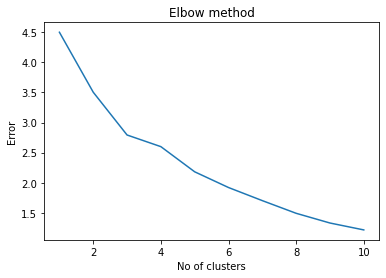

In [66]:
#Selecting the optimal number of clusters using elbow method
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i,random_state=0)
    kmeans.fit(toronto_grouped_clustering)
    Error.append(kmeans.inertia_)
#import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show() 

In [68]:
nclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"'Regent Park ', ' Harbourfront'",43.6555,-79.3626,0,Coffee Shop,Breakfast Spot,Restaurant,Dance Studio,Electronics Store,Pub,Italian Restaurant,Bakery,Thai Restaurant,Theater
9,M5B,Downtown Toronto,"'Garden District', ' Ryerson'",43.6572,-79.3783,0,Coffee Shop,Clothing Store,Hotel,Café,Middle Eastern Restaurant,Italian Restaurant,Cosmetics Shop,Movie Theater,Ramen Restaurant,Bookstore
15,M5C,Downtown Toronto,'St. James Town',43.6513,-79.3756,0,Café,Coffee Shop,Seafood Restaurant,Gastropub,Cocktail Bar,Italian Restaurant,Cosmetics Shop,Lingerie Store,Restaurant,Sporting Goods Shop
19,M4E,East Toronto,'The Beaches',43.6784,-79.2941,0,Pub,Gastropub,Health Food Store,Bakery,Park,Trail,Event Space,Electronics Store,Escape Room,Ethiopian Restaurant
20,M5E,Downtown Toronto,'Berczy Park',43.6456,-79.3754,0,Coffee Shop,Hotel,Bakery,Seafood Restaurant,Café,Japanese Restaurant,Beer Bar,Restaurant,Cocktail Bar,Deli / Bodega


In [74]:
# create map
map_clusters = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i + x + (i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters